# STD Validation

In [205]:
from qpython import qconnection 
import requests
from requests_kerberos import HTTPKerberosAuth
import pandas as pd 
import numpy as np 
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv(r"W:\UK\Risk_Control\Risk_Control_Public\MiddleOffice\Alteryx\Singapore\Output_price_check_power.csv")

In [206]:
France_bl  = data.loc[(data["Index_profile"] == "FRANCE_BL") & (data["Contract_type"] == "Month") , :]
France_bl["start_date"] = pd.to_datetime(France_bl["start_date"])
France_bl["Max"] = France_bl.loc[:, ["Ice", "EEX", "Markit", "Skylight"]].max(axis = 1 )
France_bl["Min"]  = France_bl.loc[:, ["Ice", "EEX", "Markit", "Skylight"]].min(axis = 1 )

France_bl["Validated with std"] = np.where( abs(France_bl["TGP"]  - France_bl["Markit"]) > France_bl["Markit Std"],1,0 )
France_bl["Validated with 2 prices"] = np.where((France_bl["Max"]> France_bl["TGP"]) & (France_bl["TGP"]> France_bl["Min"]) ,1,0 )

France_bl.dropna(subset = ["Markit"], inplace = True)
France_bl = round(France_bl,3)
France_bl

,Index_profile,Contract_type,start_date,TGP,Ice,EEX,Markit,Markit Std,Skylight,Max,Min,Validated with std,Validated with 2 prices
409,FRANCE_BL,Month,2022-09-01,655.000,649.50,650.00,651.521,2.367,654.272,654.272,649.500,1,0
410,FRANCE_BL,Month,2022-10-01,740.000,742.00,744.60,741.394,3.434,741.047,744.600,741.047,0,0
411,FRANCE_BL,Month,2022-11-01,1496.832,1463.89,1505.63,1496.819,12.207,1496.345,1505.630,1463.890,0,1
412,FRANCE_BL,Month,2022-12-01,1521.130,1497.01,1517.54,1505.223,10.678,1504.894,1517.540,1497.010,1,0
413,FRANCE_BL,Month,2023-01-01,1334.663,1382.16,1441.95,1383.125,35.033,1372.825,1441.950,1372.825,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,FRANCE_BL,Month,2028-08-01,165.398,NaN,NaN,148.574,0.000,NaN,148.574,148.574,1,0
481,FRANCE_BL,Month,2028-09-01,190.948,NaN,NaN,170.226,0.000,NaN,170.226,170.226,1,0
482,FRANCE_BL,Month,2028-10-01,186.732,NaN,NaN,178.092,0.000,NaN,178.092,178.092,1,0
483,FRANCE_BL,Month,2028-11-01,204.539,NaN,NaN,192.981,0.000,NaN,192.981,192.981,1,0


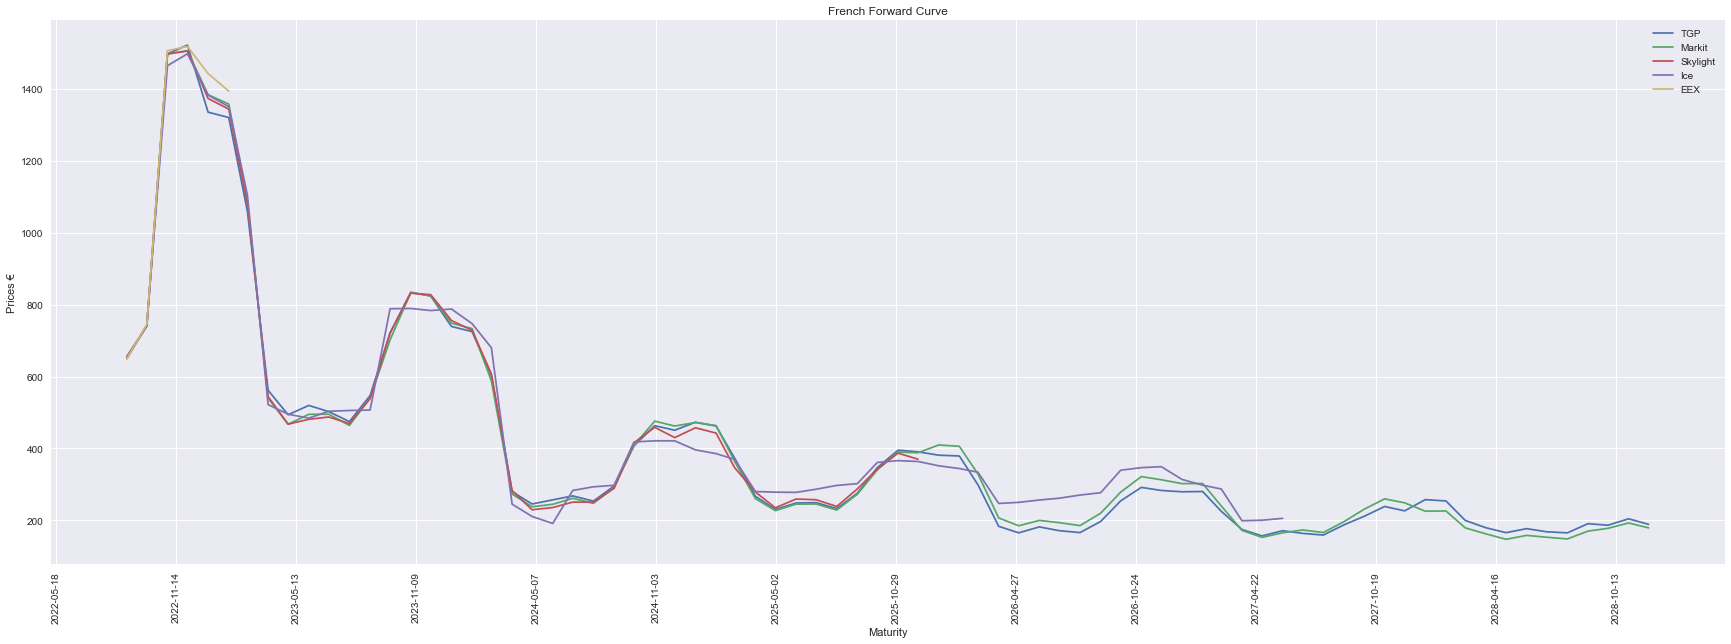

In [207]:
plt.figure(figsize = (30, 10))
plt.plot(France_bl["start_date"] , France_bl["TGP"], label = "TGP")
plt.plot(France_bl["start_date"] , France_bl["Markit"], label = "Markit")
plt.plot(France_bl["start_date"] , France_bl["Skylight"], label = "Skylight")
plt.plot(France_bl["start_date"] , France_bl["Ice"], label = "Ice")
plt.plot(France_bl["start_date"] , France_bl["EEX"], label = "EEX")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.title("French Forward Curve")
plt.xlabel("Maturity")
plt.ylabel("Prices €")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 180))
plt.legend()
plt.xticks(rotation=90); 

In [208]:
France_bl["Markit Delta"] = France_bl["TGP"] - France_bl["Markit"]

In [209]:
France_bl.head()

,Index_profile,Contract_type,start_date,TGP,Ice,EEX,Markit,Markit Std,Skylight,Max,Min,Validated with std,Validated with 2 prices,Markit Delta
409,FRANCE_BL,Month,2022-09-01,655.000,649.50,650.00,651.521,2.367,654.272,654.272,649.500,1,0,3.479
410,FRANCE_BL,Month,2022-10-01,740.000,742.00,744.60,741.394,3.434,741.047,744.600,741.047,0,0,-1.394
411,FRANCE_BL,Month,2022-11-01,1496.832,1463.89,1505.63,1496.819,12.207,1496.345,1505.630,1463.890,0,1,0.013
412,FRANCE_BL,Month,2022-12-01,1521.130,1497.01,1517.54,1505.223,10.678,1504.894,1517.540,1497.010,1,0,15.907
413,FRANCE_BL,Month,2023-01-01,1334.663,1382.16,1441.95,1383.125,35.033,1372.825,1441.950,1372.825,1,0,-48.462


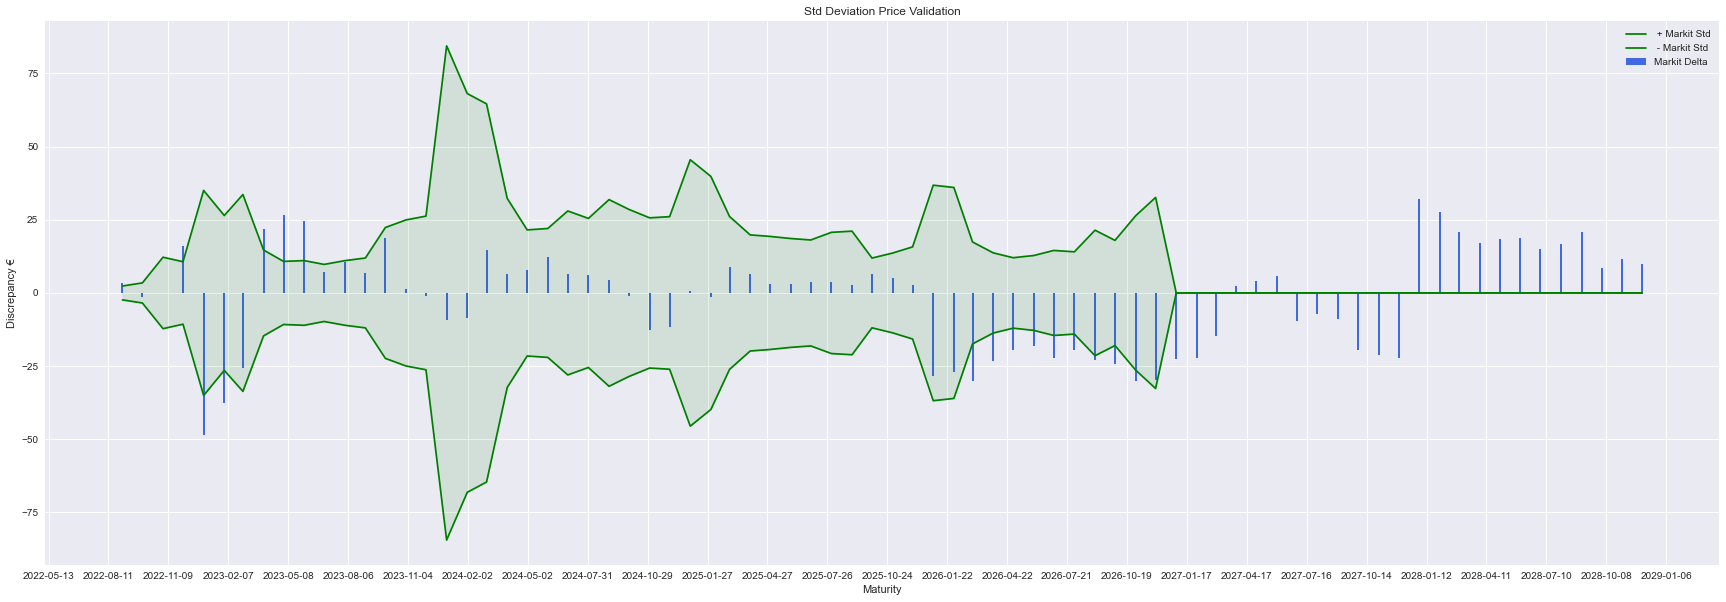

In [210]:
plt.figure(figsize = (30, 10))
plt.bar(France_bl["start_date"] , France_bl["Markit Delta"], width = 3 ,  label = "Markit Delta", color = 'royalblue')
plt.plot(France_bl["start_date"] , France_bl["Markit Std"], label = " + Markit Std",  color = 'g')
plt.plot(France_bl["start_date"] , -France_bl["Markit Std"], label = " - Markit Std",  color = 'g')
plt.fill_between(France_bl["start_date"], France_bl["Markit Std"], -France_bl["Markit Std"] , alpha = 0.1, color = 'g')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 90))
plt.title("Std Deviation Price Validation")
plt.xlabel("Maturity")
plt.ylabel("Discrepancy €")
plt.legend();